# Proyecto 2 AA3

In [13]:
!pip install gym==0.20

In [37]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random 
import pandas as pd

In [38]:
env = gym.make('Pendulum-v0')

#### Exploración inicial 

In [39]:
# Exploramos el espacio de acciones
print(env.action_space)

Box([-2.], [2.], (1,), float32)


#### Discretización

In [40]:
num_accions = 20
n_x = 20
n_y = 20
n_w = 20
accions = np.arange(int(env.action_space.low), int(env.action_space.high), (int((env.action_space.high-env.action_space.low))/num_accions))
print(accions)

[-2.0000000e+00 -1.8000000e+00 -1.6000000e+00 -1.4000000e+00
 -1.2000000e+00 -1.0000000e+00 -8.0000000e-01 -6.0000000e-01
 -4.0000000e-01 -2.0000000e-01 -4.4408921e-16  2.0000000e-01
  4.0000000e-01  6.0000000e-01  8.0000000e-01  1.0000000e+00
  1.2000000e+00  1.4000000e+00  1.6000000e+00  1.8000000e+00]


In [41]:
def discretizar(estado, seccions = (20, 20, 20), low = env.observation_space.low, high = env.observation_space.high):
    
    # Creamos unha lista cos puntos de cada intervalo
    corte_intervalos = []
    for i in range(len(seccions)):
        corte_intervalos.append(np.linspace(low[i], high[i], seccions[i]+1)[:-1])
    
    # Discretizamos a mostra en base aos puntos anteriores
    estados_discretizados = []
    for j, k in zip(estado, corte_intervalos):
        estados_discretizados.append(int(np.digitize(j, k))-1)  # Asigna a cada valor da mostra o seu intervalo correspondente e gardao nunha lista
    return estados_discretizados

### MonteCarlo control

In [42]:
def politica_aleatoria(estado, politica):
    
    # Obtemos a distribución de probabilidade
    prob = politica[estado[0],estado[1],estado[2],:]
    # Xeramos un número aleatorio entre 0 e 1
    random = np.random.random()
    # O resultado do muestreo será a acción correspondente ao intervalo no que esté contido o valor aleatorio r
    suma_prob = prob[0]
    i = 0

    while suma_prob < random:
        i+=1
        suma_prob += prob[i]

    return accions[i]

In [43]:
def simula_episodio(politica, imprimir = False, with_perturbations = False):
    done = False
    retorno = 0
    contador = 0
    recorrido = []
    estado = env.reset()
    estado_discretizado = discretizar(estado)

    while not done:
        
        accion = politica_aleatoria(estado_discretizado, politica)
        
        if with_perturbations:
            random = np.random.random()
            if random > 0.95:
                random2 = np.random.random()
                if random2 < 0.5:
                    accion = accions[0]
                else:
                    accion = accions[19]

        contador += 1
        estado, recompensa, done, _ = env.step([accion])
        estado_discretizado = discretizar(estado)        
        retorno += recompensa
        recorrido.append((estado_discretizado, accion, recompensa))
    
    if imprimir:

        print(f'Numero de paso: {contador}')
        print(f'Accion aplicada: {accion}')
        print(f'Recompensa: {retorno}')
        print(f'Terminado: {done}')
        print(f'Recorrido: {recorrido}')
    
    return (retorno, contador, recorrido)

In [44]:
def greedify_policy(q_values):

    new_shape = list(q_values.shape)
    politica = np.zeros(new_shape)

    for i in range(n_x):
        for j in range(n_y):
            for z in range(n_w):
                mejor_accion = np.nanmax(q_values[i, j, z, :])

                if not np.isnan(mejor_accion):
                    imax = q_values[i, j, z, :].tolist().index(mejor_accion)
                else:
                    imax = 0
                    
                politica[i,j,z,imax] = 1

    return politica

In [45]:
gamma = 0.9 
env._max_episode_steps = 600

def mc_control(num_episodes = 5000, epsilon=0.2, with_perturbations = False, alpha = False, imprimir = True):
    """ Función que implementa el algoritmo MonteCarlo control """
    
    qsa = np.zeros((n_x, n_y, n_w, num_accions))
    politica = np.zeros((n_x, n_y, n_w, num_accions))
    politica[:] = 1.0 / num_accions

    returns = []
    for i in range(qsa.shape[0]):
        r_i = []
        for j in range(qsa.shape[1]):
            r_j = []
            for k in range(qsa.shape[2]):
                r_k = []
                for l in range(qsa.shape[3]):
                    r_k.append([])
                r_j.append(r_k)
            r_i.append(r_j)
        returns.append(r_i)

    resultados_mc = []
    ret100 = []
    resultados100_mc = []
    for i in range(num_episodes):
        ep_return, ep_steps, episode = simula_episodio(politica, with_perturbations = with_perturbations)
        g = 0
        estados = []
        for estado, _, _ in episode:
            estados.append(estado)

        for estado, accion, retorno in reversed(episode):
            accion = accions.tolist().index(accion)
            estados.pop()
            g = gamma * g + retorno 
            if estado not in estados:
                returns[estado[0]][estado[1]][estado[2]][accion].append(g)
                qsa[estado[0]][estado[1]][estado[2]][accion] = np.average(returns[estado[0]][estado[1]][estado[2]][accion])

                A_best = np.argmax(qsa[estado[0]][estado[1]][estado[2]][:])
                for a in range(num_accions):
                    if a == A_best:
                        politica[estado[0]][estado[1]][estado[2]][a] = 1-epsilon+(epsilon/num_accions)
                    else:
                        politica[estado[0]][estado[1]][estado[2]][a] = epsilon/num_accions
        
        
        ret100.append(ep_return)
        resultados_mc.append(ep_return)
        ultimosret = ''
        if len(ret100)==101:
            ret100.pop(0)
            ultimosret=f'(retorno medio de {np.mean(ret100)} en los últimos 100 episodios)'
            resultados100_mc.append(np.mean(ret100))
        if imprimir:
            print(f'Terminado episodio {i} con retorno {ep_return} en {ep_steps} pasos {ultimosret}')
        
    return politica, resultados_mc, resultados100_mc

In [85]:
policy_montecarlo , resultados_mc, resultados100_mc = mc_control(num_episodes = 4000)
print('\nA media de todos os episodios é',np.mean(resultados_mc))

Terminado episodio 0 con retorno -4885.162980222146 en 600 pasos 
Terminado episodio 1 con retorno -2881.840182007731 en 600 pasos 
Terminado episodio 2 con retorno -3480.697693380752 en 600 pasos 
Terminado episodio 3 con retorno -4752.824045825342 en 600 pasos 
Terminado episodio 4 con retorno -4242.823460336381 en 600 pasos 
Terminado episodio 5 con retorno -4539.885217854401 en 600 pasos 
Terminado episodio 6 con retorno -4679.924685743963 en 600 pasos 
Terminado episodio 7 con retorno -4693.507553999618 en 600 pasos 
Terminado episodio 8 con retorno -4342.383854556424 en 600 pasos 
Terminado episodio 9 con retorno -4402.920961533309 en 600 pasos 
Terminado episodio 10 con retorno -4431.9798342021395 en 600 pasos 
Terminado episodio 11 con retorno -4231.067001914721 en 600 pasos 
Terminado episodio 12 con retorno -4374.692104541276 en 600 pasos 
Terminado episodio 13 con retorno -4233.077994682985 en 600 pasos 
Terminado episodio 14 con retorno -4221.963352524291 en 600 pasos 
Term

### SARSA

In [46]:
gamma = 0.9
env._max_episode_steps = 600 


def get_random_state():
    return [random.randrange(n_x),random.randrange(n_y),random.randrange(n_w)]

In [47]:
def get_epsilon_greedy_action(q_values, epsilon):
    
    if np.random.random() < epsilon:
        return random.randrange(num_accions)
    
    return q_values.index(max(q_values))

In [48]:
def sarsa(num_episodes = 500, alpha = 0.1, epsilon = 0.25, with_perturbations=False, imprimir = True):

    q_values = np.zeros((n_x, n_y, n_w, num_accions))
    
    last100returns = []
    returns_total = []
    resultados100_sarsa = []

    for episode in range(num_episodes):
            
        env.reset()
        S = get_random_state()
        accion = get_epsilon_greedy_action(q_values[S[0],S[1],S[2],:].tolist(), epsilon)
        
        if with_perturbations:
            random = np.random.random()
            if random > 0.95:
                random2 = np.random.random()
                if random2 < 0.5:
                    accion = 0
                else:
                    accion = 19
                    
        returns = 0
        num_steps = 0
        done = False
        while not done:
            num_steps += 1
            estado, retorno, done, _ = env.step([accions[accion]])
            S_prima = discretizar(estado)
            returns += retorno
            A_prima = get_epsilon_greedy_action(q_values[S_prima[0],S_prima[1],S_prima[2],:].tolist(), epsilon)
            # Q(S,A) <- Q(S,A) + ALPHA * [R + GAMMA * Q(S',A') - Q(S,A)]
            q_values[S[0],S[1],S[2],accion] = q_values[S[0],S[1],S[2],accion] + alpha * (retorno + gamma * q_values[S_prima[0],S_prima[1],S_prima[2],A_prima] - q_values[S[0],S[1],S[2],accion])
            S = S_prima
            accion = A_prima

        last100returns.append(returns)
        returns_total.append(returns)
        string_retornos100 = ''
        if len(last100returns)==101:
            last100returns.pop(0) 
            resultados100_sarsa.append(np.mean(last100returns))
            string_retornos100=f'(retorno medio de {np.mean(last100returns)} en los últimos 100 episodios)'
            
        if imprimir:
            print(f'Terminado episodio {episode} con retorno {returns} en {num_steps} pasos {string_retornos100}')
    return q_values, returns_total, resultados100_sarsa

In [86]:
q_values_sarsa, returns, resultados100_sarsa = sarsa(num_episodes = 4000)
print('\nA media de todos os episodios é',np.mean(returns))

Terminado episodio 0 con retorno -4446.666251107767 en 600 pasos 
Terminado episodio 1 con retorno -5036.596610306088 en 600 pasos 
Terminado episodio 2 con retorno -4271.121256856277 en 600 pasos 
Terminado episodio 3 con retorno -3650.8200002769345 en 600 pasos 
Terminado episodio 4 con retorno -4960.489688606077 en 600 pasos 
Terminado episodio 5 con retorno -3260.7401590676463 en 600 pasos 
Terminado episodio 6 con retorno -2817.995375224928 en 600 pasos 
Terminado episodio 7 con retorno -2557.883982113241 en 600 pasos 
Terminado episodio 8 con retorno -4520.154207153497 en 600 pasos 
Terminado episodio 9 con retorno -4104.631961034962 en 600 pasos 
Terminado episodio 10 con retorno -2565.869906328289 en 600 pasos 
Terminado episodio 11 con retorno -3210.1242198653513 en 600 pasos 
Terminado episodio 12 con retorno -3244.6229978499014 en 600 pasos 
Terminado episodio 13 con retorno -3076.4229540996694 en 600 pasos 
Terminado episodio 14 con retorno -3149.489152404534 en 600 pasos 


### Q-learning

In [50]:
def q_learning(num_episodes = 500, alpha = 0.1, epsilon = 0.25, with_perturbations=False, imprimir = True):
    
    q_values = np.zeros((n_x, n_y, n_w, num_accions))
    
    last100returns = []
    returns_total = []
    resultados100_ql = []
    
    for episode in range(num_episodes):

        env.reset()
        S = get_random_state()
        returns = 0
        num_steps = 0

        done = False
        while not done:
            num_steps += 1
            accion = get_epsilon_greedy_action(q_values[S[0],S[1],S[2],:].tolist(), epsilon)
        
            if with_perturbations:
                random = np.random.random()
                if random > 0.95:
                    random2 = np.random.random()
                    if random2 < 0.5:
                        accion = 0
                    else:
                        accion = 19
                    
            estado, retorno, done, _ = env.step([accions[accion]])
            S_prima = discretizar(estado)
            returns += retorno
            
            q_values[S[0],S[1],S[2],accion] = q_values[S[0],S[1],S[2],accion] + alpha * (retorno + gamma * np.max(q_values[S_prima[0],S_prima[1],S_prima[2],:]) - q_values[S[0],S[1],S[2],accion])
                
            # S <- S'
            S = S_prima

        last100returns.append(returns)
        returns_total.append(returns)
        string_retornos100 = ''
        if len(last100returns)==101:
            last100returns.pop(0) 
            string_retornos100=f'(retorno medio de {np.mean(last100returns)} en los últimos 100 episodios)'
            resultados100_ql.append(np.mean(last100returns))
            
        if imprimir:
            print(f'Terminado episodio {episode} con retorno {returns} en {num_steps} pasos {string_retornos100}')
        
    return q_values, returns_total, resultados100_ql

In [87]:
q_values_q, resultados_qlearn, resultados100_ql = q_learning(num_episodes = 4000)
print('\nA media de todos os episodios é',np.mean(resultados_qlearn))

Terminado episodio 0 con retorno -3851.6750076317808 en 600 pasos 
Terminado episodio 1 con retorno -4169.691983444524 en 600 pasos 
Terminado episodio 2 con retorno -3473.456554312967 en 600 pasos 
Terminado episodio 3 con retorno -3065.978423012232 en 600 pasos 
Terminado episodio 4 con retorno -4465.800816427707 en 600 pasos 
Terminado episodio 5 con retorno -2812.4269424236045 en 600 pasos 
Terminado episodio 6 con retorno -4982.192739557522 en 600 pasos 
Terminado episodio 7 con retorno -3787.527214404489 en 600 pasos 
Terminado episodio 8 con retorno -3942.2837454973824 en 600 pasos 
Terminado episodio 9 con retorno -2701.564596116255 en 600 pasos 
Terminado episodio 10 con retorno -2988.774519740976 en 600 pasos 
Terminado episodio 11 con retorno -3311.5272869053206 en 600 pasos 
Terminado episodio 12 con retorno -3366.917369876243 en 600 pasos 
Terminado episodio 13 con retorno -4548.575777109702 en 600 pasos 
Terminado episodio 14 con retorno -3891.8398231024494 en 600 pasos 


### Expected SARSA

In [52]:
def expected_sarsa(num_episodes = 500, alpha = 0.1, epsilon = 0.25, with_perturbations=False, imprimir = True):

    q_values = np.zeros((n_x, n_y, n_w, num_accions))
    
    last100returns = []
    returns_total = []
    resultados100_eSarsa = []
    
    for episode in range(num_episodes):
            
        env.reset()
        S = get_random_state()
        returns = 0
        num_steps = 0
        done = False
        
        while not done:
            num_steps += 1
            accion = get_epsilon_greedy_action(q_values[S[0],S[1],S[2],:].tolist(), epsilon)
        
            if with_perturbations:
                random1 = np.random.random()
                if random1 > 0.95:
                    random2 = np.random.random()
                    if random2 < 0.5:
                        accion = 0
                    else:
                        accion = 19
                    
            estado, retorno, done, _ = env.step([accions[accion]])
            S_prima = discretizar(estado)
            returns += retorno

            a_max = np.argmax(q_values[S_prima[0],S_prima[1],S_prima[2],:])
            expected_value = np.sum(np.multiply((epsilon/num_accions),q_values[S_prima[0],S_prima[1],S_prima[2],:])) + (1 - epsilon)*q_values[S_prima[0],S_prima[1],S_prima[2],a_max]
            q_values[S[0],S[1],S[2],accion] += alpha * (retorno + gamma * expected_value - q_values[S[0],S[1],S[2],accion])
                
            # S <- S'
            S = S_prima

        last100returns.append(returns)
        returns_total.append(returns)
        string_retornos100 = ''
        if len(last100returns)==101: 
            last100returns.pop(0) 
            resultados100_eSarsa.append(np.mean(last100returns))
            string_retornos100=f'(retorno medio de {np.mean(last100returns)} en los últimos 100 episodios)'
      
        if imprimir:
            print(f'Terminado episodio {episode} con retorno {returns} en {num_steps} pasos {string_retornos100}')
    return q_values, returns_total, resultados100_eSarsa

In [90]:
esarsa_q_values, resultados_expected, resultados100_esarsa = expected_sarsa(num_episodes = 4000)
print('\nA media de todos os episodios é',np.mean(resultados_expected)) 

Terminado episodio 0 con retorno -4871.543269943359 en 600 pasos 
Terminado episodio 1 con retorno -5119.222605111118 en 600 pasos 
Terminado episodio 2 con retorno -4343.125733523582 en 600 pasos 
Terminado episodio 3 con retorno -3582.6489530565473 en 600 pasos 
Terminado episodio 4 con retorno -3272.0107140357463 en 600 pasos 
Terminado episodio 5 con retorno -2841.148413144748 en 600 pasos 
Terminado episodio 6 con retorno -4492.3642529150775 en 600 pasos 
Terminado episodio 7 con retorno -3122.284691580887 en 600 pasos 
Terminado episodio 8 con retorno -2656.2182631128626 en 600 pasos 
Terminado episodio 9 con retorno -2165.0199844207386 en 600 pasos 
Terminado episodio 10 con retorno -4532.4788954504165 en 600 pasos 
Terminado episodio 11 con retorno -3609.5715616464963 en 600 pasos 
Terminado episodio 12 con retorno -2664.9309539937317 en 600 pasos 
Terminado episodio 13 con retorno -2932.796273711344 en 600 pasos 
Terminado episodio 14 con retorno -3269.259586729726 en 600 paso

# Axuste de parámetros

In [53]:
alpha = [0.1, 0.4, 0.7]
epsilon =  [0.1, 0.2, 0.4]

In [54]:
results = {}
algoritmos = [mc_control, sarsa, q_learning, expected_sarsa]
for algoritmo in algoritmos:
        print('Comezamos a exploración do algoritmo', algoritmo.__name__)
        results[algoritmo] = {}
        for al in alpha:
                for ep in epsilon:
                    print('Probamos a combinación alpha =', al, 'y epsilon =', ep)
                    results[algoritmo][(al, ep)] = 0
                    _ , resultados, _ = algoritmo(num_episodes = 500, epsilon = ep, alpha = al, imprimir = False)
                    results[algoritmo][(al, ep)] = np.mean(resultados)

Comezamos a exploración do algoritmo mc_control
Probamos a combinación alpha = 0.1 y epsilon = 0.1
Probamos a combinación alpha = 0.1 y epsilon = 0.2
Probamos a combinación alpha = 0.1 y epsilon = 0.4
Probamos a combinación alpha = 0.4 y epsilon = 0.1
Probamos a combinación alpha = 0.4 y epsilon = 0.2
Probamos a combinación alpha = 0.4 y epsilon = 0.4
Probamos a combinación alpha = 0.7 y epsilon = 0.1
Probamos a combinación alpha = 0.7 y epsilon = 0.2
Probamos a combinación alpha = 0.7 y epsilon = 0.4
Comezamos a exploración do algoritmo sarsa
Probamos a combinación alpha = 0.1 y epsilon = 0.1
Probamos a combinación alpha = 0.1 y epsilon = 0.2
Probamos a combinación alpha = 0.1 y epsilon = 0.4
Probamos a combinación alpha = 0.4 y epsilon = 0.1
Probamos a combinación alpha = 0.4 y epsilon = 0.2
Probamos a combinación alpha = 0.4 y epsilon = 0.4
Probamos a combinación alpha = 0.7 y epsilon = 0.1
Probamos a combinación alpha = 0.7 y epsilon = 0.2
Probamos a combinación alpha = 0.7 y epsil

In [64]:
best_results = {}
for algoritmo in algoritmos:
    best_result = max(results[algoritmo], key=results[algoritmo].get)
    best_results[algoritmo] = (best_result, results[algoritmo][best_result])
    print('Mejor resultado para', algoritmo.__name__, ':','alpha =', best_results[algoritmo][0][0], 'epsilon =', best_results[algoritmo][0][1], 'con un retorno medio de', best_results[algoritmo][1])

Mejor resultado para mc_control : alpha = 0.4 epsilon = 0.4 con un retorno medio de -3733.697331195355
Mejor resultado para sarsa : alpha = 0.7 epsilon = 0.1 con un retorno medio de -3310.041008214523
Mejor resultado para q_learning : alpha = 0.7 epsilon = 0.1 con un retorno medio de -3239.9829609173917
Mejor resultado para expected_sarsa : alpha = 0.7 epsilon = 0.1 con un retorno medio de -3174.2595760807253


#  Comprobación da política determinista máis efectiva

In [56]:
def episodios_test(policy, n_episodios):
    """Genera n episodios de test con la política dada y devuelve las recompensas de cada episodio."""
    
    test_rewards = []
    
    for episodio in range(n_episodios):    
        env.reset()
        state = get_random_state()
        state_discrete = discretizar(state)
        
        done = False
        returns = 0
        
        while True:
            
            action = np.argmax(policy[state_discrete[0],state_discrete[1],state_discrete[2], :])
            state, recom, done, _ = env.step([accions[action]])
            state_discrete = discretizar(state)
            
            returns += recom

            if done:
                test_rewards.append(returns)
                break
                
    return test_rewards

In [92]:
greedy_mc = greedify_policy(policy_montecarlo)

n_episodios = 200

print("Executando", n_episodios, "episodios co algoritmo Montecarlo control:")
det_mc = episodios_test(greedy_mc, n_episodios)
print('A media das recompensas é',np.mean(det_mc),' (con desviación típica',np.std(det_mc),')')

print("\nExecutando", n_episodios, "episodios co algoritmo SARSA:")
_ , det_sarsa, _ = sarsa(num_episodes = n_episodios, alpha = 0.7, epsilon = 0, imprimir = False)
print('La media de las recompensas es',np.mean(det_sarsa),'(con desviación típica',np.std(det_sarsa),')') 

print("\nExecutando", n_episodios, "espisodios co algoritmo Q-learning:")
_ , det_ql, _ = q_learning(num_episodes = n_episodios, alpha = 0.7, epsilon = 0, imprimir = False)
print('La media de las recompensas es',np.mean(det_ql),' (con desviación típica',np.std(det_ql),')') 

print("\nExecutando", n_episodios, "episodios co algoritmo Expected SARSA:")
_ , det_esarsa, _ = expected_sarsa(num_episodes = n_episodios, alpha = 0.7, epsilon = 0, imprimir = False)
print('A media das recompensas é',np.mean(det_esarsa),' (con desviación típica',np.std(det_esarsa),')') 

Executando 200 episodios co algoritmo Montecarlo control:
A media das recompensas é -2994.1905034764295  (con desviación típica 997.4320497404493 )

Executando 200 episodios co algoritmo SARSA:
La media de las recompensas es -3540.835102081342 (con desviación típica 816.16487398771 )

Executando 200 espisodios co algoritmo Q-learning:
La media de las recompensas es -3497.766517582289  (con desviación típica 760.6856005391357 )

Executando 200 episodios co algoritmo Expected SARSA:
A media das recompensas é -3550.706730841197  (con desviación típica 672.9298585413648 )


# Comparación de retornos durante a aprendizaxe

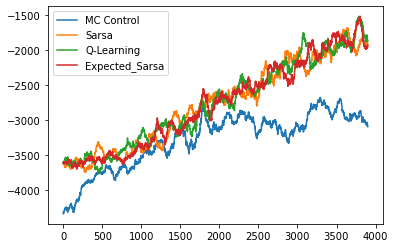

In [91]:
# Representamos las medias de los retornos durante los últimos 100 episodios a lo largo del aprendizaje
df = pd.DataFrame({"MC Control": resultados100_mc,
             "Sarsa": resultados100_sarsa, 
             "Q-Learning": resultados100_ql, 
             "Expected_Sarsa": resultados100_esarsa})

df.plot()

# Introducindo perturbacións

In [ ]:
policy_mc_pert, _, _ = mc_control(num_episodes = 200, epsilon = 0.4, with_perturbations = True, imprimir = False)
greedy_mc_pert = greedify_policy(policy_mc_pert)

n_episodios = 200

print("Executando", n_episodios, "episodios co algoritmo Montecarlo control:")
det_mc = episodios_test(greedy_mc, n_episodios)

print("\nExecutando", n_episodios, "episodios co algoritmo SARSA:")
_ , det_sarsa_pert, _ = sarsa(num_episodes = n_episodios, alpha = 0.7, epsilon = 0.1, with_perturbations = True, imprimir = False)

print("\nExecutando", n_episodios, "espisodios co algoritmo Q-learning:")
_ , det_ql_pert, _ = q_learning(num_episodes = n_episodios, alpha = 0.7, epsilon = 0.1, with_perturbations = True, imprimir = False)

print("\nEcecutando", n_episodios, "episodios co algoritmo Expected SARSA:")
_ , det_esarsa_pert, _ = expected_sarsa(num_episodes = n_episodios, alpha = 0.7, epsilon = 0.1, with_perturbations = True,imprimir = False)


In [96]:
print('A media das recompensas é',np.mean(det_mc),' (con desviación típica',np.std(det_mc),')')
print('La media de las recompensas es',np.mean(det_sarsa_pert),'(con desviación típica',np.std(det_sarsa_pert),')') 
print('La media de las recompensas es',np.mean(det_ql_pert),' (con desviación típica',np.std(det_ql_pert),')') 
print('A media das recompensas é',np.mean(det_esarsa_pert),' (con desviación típica',np.std(det_esarsa_pert),')') 

A media das recompensas é -3118.8887590605464  (con desviación típica 1097.7696057225298 )
La media de las recompensas es -3563.9933925905148 (con desviación típica 707.1394364014059 )
La media de las recompensas es -3546.931165923416  (con desviación típica 677.0386389526875 )
A media das recompensas é -3560.0153077908476  (con desviación típica 652.6639754908927 )
